### Measuring $T_1$ and $T_2$ for a qubit <a id="importing"></a>

In the previous exercises, we always assumed that we have a "ideal" quantum computer, such that we can apply each gate without any error and obtain the correct result. However, this is not the case for real devices. Instead, the quantum computers are experimental platforms which suffer from unwanted coupling to the environment and "crosstalk", i.e the application of gates on a given qubit can have unwanted effects on neighboring qubits.

It is therefore crucial to understand the origin of errors in more detail and to quantify them. In fact, the systematic investigation of errors in real devices is an active field of research, especially in industrial companies.

Two of the most common quantities to characterize the quality of single qubits are $T_1$ and $T_2$. These are two characteristic timescales to specify the quality of a qubit. 

While $T_1$ denotes the time it takes for an excited qubit to decay into the ground state, 
$T_2$ characterizes the damping of off-diagonal elements in the density matrix, which can be interpreted as the time that a qubit persists in a coherent state. 

The quantum computers of IBM consist of [superconducting qubits](https://en.wikipedia.org/wiki/Superconducting_quantum_computing). The gates and measurments are applied via microwave pulses. In experiments, after a gate calibration the quality of the qubits is benchmarked by measuring $T_1$ and $T_2$. 
In the following exercise, you learn how to measure this quantities on a real quantum device. 
To do so, we assume that our gates already calibrated and can use then $X$ and $\sqrt{X}$ gates to perform the measurments. 

## 1. Getting Started <a id="importing"></a>

We'll first get our basic dependencies set up and ready to go. Since we want to use real, noisy devices for our calibration experiments in this notebook, we need to load our IBMQ account and set the appropriate backend. We also need the numpy and matplotlib library to analyze our results.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from qiskit import IBMQ

IBMQ.save_account("740cf9a029345b5770ad72af52ca4d1c51eb8afe78c6d95e17ecffd2e72033a693cf8563418f2143cf5d9780f497e3100577f0a400d882f5d4314ca68ce9fc37",overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2',group='max-planck-inst',project='codingchallenge')
backend = provider.get_backend('ibmq_jakarta')

from qiskit.providers.aer import AerSimulator #A library to simulate quantum computers with noise on a classical device 
backend2= AerSimulator.from_backend(backend)  #Simulator backend, in case computations on areal quantum computing device take too long

ibmqfactory.load_account:WARNING:2022-09-15 11:12:02,340: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
import numpy as np

In order to measure the timescales, we have to insert some "waiting times" into the circuit. This we can done by adding an instruction qc_t1.delay(delay, 0), where delay denotes the time of the circuit to do nothing. At the end our circuit will be translated in a pulse schedule as shown below:

![balanced1.png](Pulseschedule.png)

The schedule shows all ingredients we need for measuring the $T_1$ time.
The first pulse corresponds to applying a $X$-gate of the qubit. Then we insert manually a delay. At the end, another pulse is applied to read-out the qubit.
Qiskit has also an extension [qiskit-pulse](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html) which allows to manually calibrate qubits and to create custom gates on a pulse level.

Do not worry, we will not use qiskit pulse in this exercise. Instead, we can use predefined gates to build our experiments.

However, the delay time has to be consistent with internal restrictions of the machine, i.e has to be an integral multiple of the minimum pulse length of the corresponding quantum computer. The first few paragraphs extract the necessary parameters to build the circuits for $T_1$ and $T_2$ respecting these constraints.

To begin with, we can find the sampling time for the backend pulses within the backend configuration. This will be a very useful value to us as we build and execute our calibration routines.

In [6]:
backend_config = backend.configuration()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [7]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

We can also find timing constraints in the backend configuration.

The position of the measurement pulse is constrained to be an integral multiple of `acquire_alignment`, and the position of the gate is constrained to be an integral multiple of` pulse_alignment`.

We can use `granurality` to determine the length of the pulse.

In [8]:
backend.configuration().timing_constraints

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity       = backend.configuration().timing_constraints['granularity']
pulse_alignment   = backend.configuration().timing_constraints['pulse_alignment']
lcm               = np.lcm(acquire_alignment, pulse_alignment)

print(f"Lowest common multiple of acquire_alignment and pulse_alignment: {lcm}")

Lowest common multiple of acquire_alignment and pulse_alignment: 16


For the following experiments, we need a delay time between pulses. However, due to backend constraints this time cannot be arbitrary but has to be a multiple of 16 of the minimum time interval of the backend $dt$. The following functions assure that this is the case for our protocol.

In [9]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

We prepare a function to determine the length of the pulse.

In [10]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

We prepare a function to adjust the length of the delay.

In [11]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

Now we have all the ingredients to build our experiments!

---
---
### 2. Measuring $T_1$ using Inversion Recovery <a id="T1"></a>
The $T_1$ time of a qubit is the time it takes for a qubit to decay from the excited state to the ground state. It is important because it limits the duration of meaningful programs we can run on the quantum computer.

Measuring $T_1$ is straightforward. We apply a single $X$-gate to excite the qubit, then apply a measure pulse. However, this time we do not apply the measurement immediately. We insert a delay, and vary that delay between experiments. When we plot the measured signal against delay time, we will see a signal that decays exponentially as the qubit relaxes in energy. The decay time is the $T_1$, or relaxation time, of the qubit!

In [12]:
# T1 experiment parameters
time_max_sec    = 450 * us
time_step_sec   = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

We can now setup the experiments to measure $T_1$.

In [13]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)


exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

Let's have a look at our circuit

In [14]:
qc_t1.draw()

┌───┐┌──────────────────┐┌─┐
  q: ┤ X ├┤ Delay(delay[dt]) ├┤M├
     └───┘└──────────────────┘└╥┘
c: 1/══════════════════════════╩═
                               0

The next task is to execute the results. 

If it takes to long on a real quantum device, you can replace backend by backend2 (for a noisy simulation on a classical computer).

In [15]:
# Execution settings
num_shots = 256
#either backend2 (classical simulation) or backend (run on quantum computer)

# Quantum Device
"""
job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots,
                  memory=False)
"""

# Classical Device
job = backend2.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots,
                  memory=False)


job_monitor(job)

Job Status: job has successfully run


We can now extraxt the fraction of states still being in the excited state after some delay time.

In [16]:
t1_results = job.result(timeout=120)
counts     = t1_results.get_counts()
t1_values  = []

for i in range(len(delay_times_sec)):
    excited=counts[i]['1']
    
    #iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(excited/ num_shots)



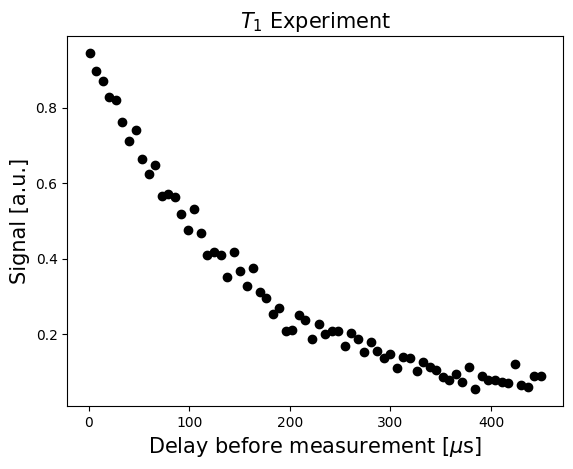

In [17]:
plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)

#plt.yscale("log")

plt.show()

We can then fit the data to a decaying exponential, giving us T1!

In [18]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

---
$\color{red}{\text{Exercise: obtain T_1 from an exponential fit!}}$

$\color{green}{\text{Solution}}$

In [19]:
##Exercise: Fit the outcome to obtain T1!

exp_fctn      = lambda t, τ, y0: y0*np.exp(-t/τ)
initial_guess = [100, 0.9]

fitparams, y_fit = fit_function(delay_times_sec/us, t1_values, exp_fctn, initial_guess)

print(fitparams)
T1 = fitparams[0]

[155.02550539   0.94824705]


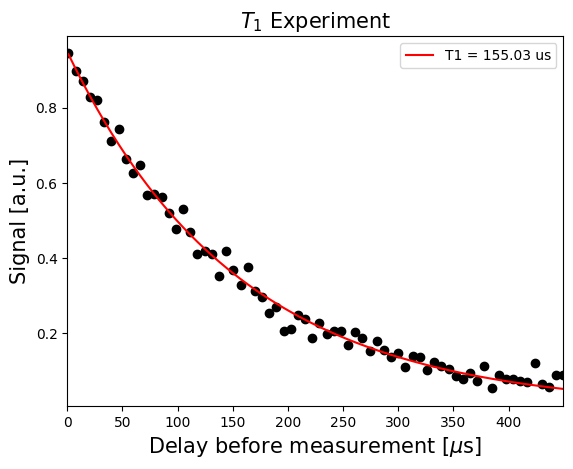

In [20]:
plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")

plt.xlim(0, np.max(delay_times_sec/us))

plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

---
$\color{red}{\text{Question: Why is the fraction of states in the excited state not 1 at }T=0\,?}$

$\color{green}{\text{Solution}}$

Possible additional errors:
- finite gate infidelity
- finite measurement error
- finite state preparation infidelity

----
---
### 3. Measuring $T_2$ using Hahn Echoes <a id="hahn"></a>

Next, we measure the coherence time, $T_2$, of our qubit, which can be interepreted as the time a qubit survives in a coherent superposition.

To measure the coherence time, $T_2$, we initialize our qubit in an equal superposition of ground and excited state by applying a $\sqrt{X}$-gate: $\sqrt{X} |0\rangle =  (|0\rangle  + i |1\rangle )/\sqrt{2}$.

In order to distinguish the spin relaxation from (unitary) decoherence we make use of a pulse sequence known as a [Spin echo/ Hahn echo](https://en.wikipedia.org/wiki/Spin_echo), a term that comes from the NMR community. 
To this end, we apply a $X$ gate at a time $\tau$ after the $\sqrt{X}$-gate which reverses the (unitary) accumulation of phase, and results in an echo at time $2\tau$ which is reduced in amplitude only due to the irreversible spin relaxation.

Finally, we apply the last $\pi/2$ pulse to do our measurement. 

The circuit for the Hahn Echo can be represented as
![balanced1.png](hahn_echo_circuit.png)

The decay time for the Hahn echo experiment gives us the coherence time, $T_2$.

In [21]:
# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

---
$\color{red}{\text{Exercise: prepare a parametric circuit to determine } T_2 \text{using the Hahn echo. You can orientate on the circuits used to determine } T_1}$

$\color{green}{\text{Solution}}$

In [22]:
delay = Parameter('delay') #use parametrized circuits. We fix the parameter of the circuit later.
qc_t2 = QuantumCircuit(1, 1)

"Implement circuit here"
qc_t2.sx(0)
qc_t2.delay(delay, 0)
qc_t2.x(0)
qc_t2.delay(delay, 0)
qc_t2.sx(0)
qc_t2.measure(0, 0)

exp_t2_circs = [qc_t2.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

In [23]:
# Check Circuit
qc_t2.draw(filename='hahn_echo_circuit.png')#, output='mpl')

┌────┐┌──────────────────┐┌───┐┌──────────────────┐┌────┐┌─┐
  q: ┤ √X ├┤ Delay(delay[dt]) ├┤ X ├┤ Delay(delay[dt]) ├┤ √X ├┤M├
     └────┘└──────────────────┘└───┘└──────────────────┘└────┘└╥┘
c: 1/══════════════════════════════════════════════════════════╩═
                                                               0

The next task is to execute the results. 

If it takes to long on a real quantum device, you can replace backend by backend2 (for a noisy simulation on a classical computer).

In [24]:
# Execution settings
num_shots_per_point = 512
#If it takes to long replace backend by backend2
"""
# Quantum Device
job = backend.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point,
                  memory=False)
"""

# Classical Simulation
job = backend2.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point,
                  memory=False)

job_monitor(job)

Job Status: job has successfully run


Let's have a look at the data

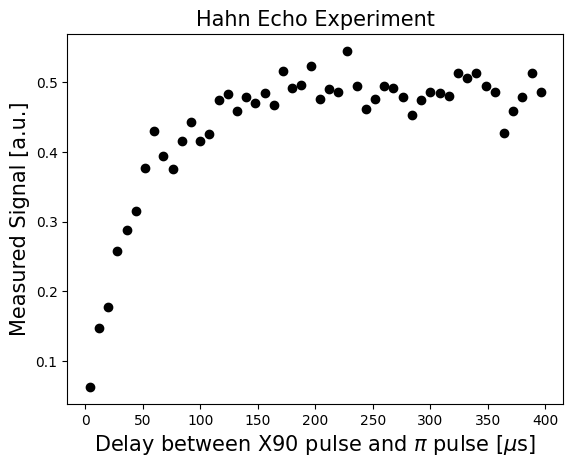

In [25]:
t2_results = job.result(timeout=120)
counts     = t2_results.get_counts()
t2_values  = []

for i in range(len(delay_times_sec)):
    excited=counts[i]['1']
    t2_values.append(excited/ num_shots_per_point)


plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

---
$\color{red}{\text{Exercise: fit again the results to obtain } T_2.}$

$\color{green}{\text{Solution}}$

In [26]:
##Exercise: Fit the outcome to obtain T2!

exp2_fctn     = lambda t, τ, y0, a: (1 - y0*np.exp(-t/τ))*a
initial_guess = [100, 0.9, 0.5]

fitparams2, y_fit2 = fit_function(2*delay_times_sec/us, t2_values, exp2_fctn, initial_guess)

print(fitparams2)
T2 = fitparams2[0]

[41.48103109  0.96062418  0.4890287 ]


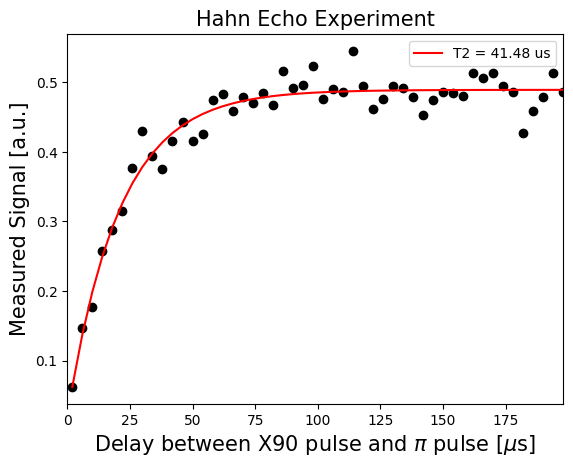

In [27]:
plt.scatter(delay_times_sec/us, t2_values, color='black')
plt.plot(delay_times_sec/us, y_fit2, color='red', label=f"T2 = {T2:.2f} us")

plt.xlim(0, np.max(delay_times_sec/us))

plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

---
$\color{red}{\text{Bonus question: You used time delay to determine both } T_1 \text{ and } T_2. \text{Is there a relation, for example an (in-)equality connecting these quantities?}}$

$\color{green}{\text{Solution}}$

Yes!

Consider that applying the $\sqrt{X}$ gate will lead to $\sqrt{X} |0> =  (|0>  + i |1> )/\sqrt{2}$ and note that the lifetime of the excited state $|1>$ is given by $T_1$.
Therefore, even if there was no additional decoherence $T_2$ would be limited by the decay time of the excited plateau, i.e. the relaxation time $T_1$.

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.